Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Load train, test, and gender_submission datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

data preprocessing 

In [4]:
# Display basic information about train data
print(train_data.info())

# Display summary statistics
print(train_data.describe())

# Display the first few rows of the train dataset
print(train_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

Handle Missing Values:

In [5]:
# Display the number of missing values in each column of the train dataset
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [9]:

# One-hot encode 'Sex' and 'Embarked' columns
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'])
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'])


In [18]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Sex_female   891 non-null    uint8  
 10  Sex_male     891 non-null    uint8  
 11  Embarked_C   891 non-null    uint8  
 12  Embarked_Q   891 non-null    uint8  
 13  Embarked_S   891 non-null    uint8  
dtypes: float64(2), int64(5), object(2), uint8(5)
memory usage: 67.1+ KB
None


In [10]:
# Impute missing values in the 'Age' column with the mean
mean_age = train_data['Age'].mean()
train_data['Age'].fillna(mean_age, inplace=True)
test_data['Age'].fillna(mean_age, inplace=True)

In [11]:
# Drop the 'Cabin' column
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)


Visualize the Data

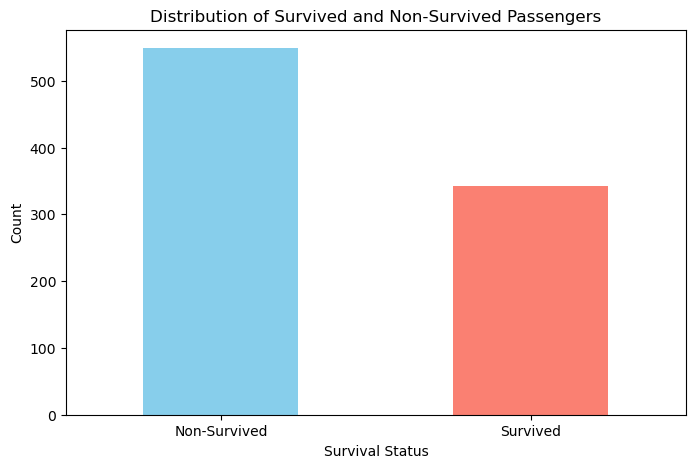

In [14]:
# Plot the distribution of survived and non-survived passengers
plt.figure(figsize=(8, 5))
train_data['Survived'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Survived and Non-Survived Passengers')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Survived', 'Survived'], rotation=0)
plt.show()

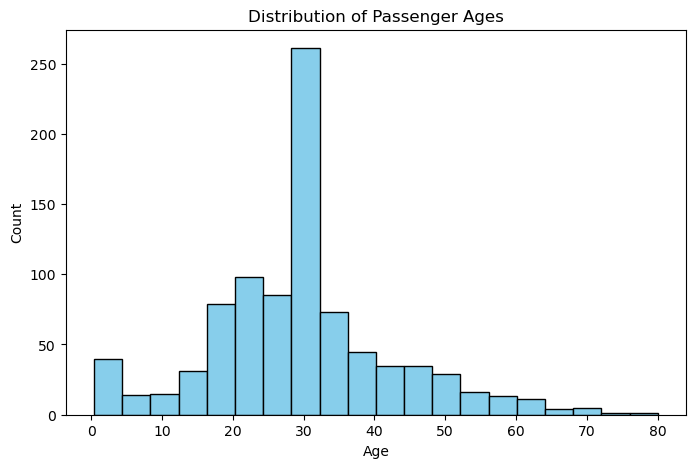

In [15]:
# Plot the distribution of passenger ages
plt.figure(figsize=(8, 5))
plt.hist(train_data['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Passenger Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [16]:
import seaborn as sns


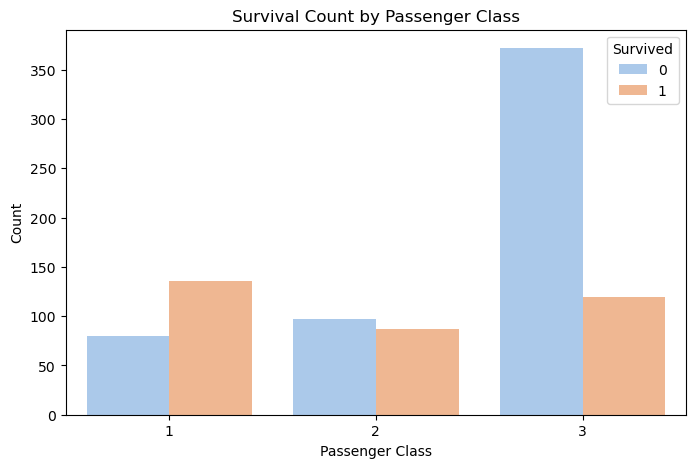

In [17]:
# Import Seaborn
import seaborn as sns

# Plot the relationship between Pclass and survival
plt.figure(figsize=(8, 5))
sns.countplot(x='Pclass', hue='Survived', data=train_data, palette='pastel')
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()


# Naive Bayes algorithm

In [19]:
def separate_by_class(X, y):
    separated = {}
    for i in range(len(X)):
        features = X.iloc[i]
        label = y.iloc[i]
        if label not in separated:
            separated[label] = []
        separated[label].append(features)
    return separated


In [20]:
def calculate_statistics(data):
    statistics = [(np.mean(attribute), np.std(attribute)) for attribute in zip(*data)]
    return statistics


In [21]:
def summarize_dataset(X, y):
    separated = separate_by_class(X, y)
    summaries = {}
    for class_value, instances in separated.items():
        summaries[class_value] = calculate_statistics(instances)
    return summaries


In [22]:
def calculate_probability(x, mean, std):
    exponent = np.exp(-((x - mean)**2 / (2 * std**2)))
    return (1 / (np.sqrt(2 * np.pi) * std)) * exponent


In [23]:
def calculate_class_probabilities(summaries, input_vector):
    probabilities = {}
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = 1
        for i in range(len(class_summaries)):
            mean, std = class_summaries[i]
            x = input_vector[i]
            probabilities[class_value] *= calculate_probability(x, mean, std)
    return probabilities


In [24]:
def predict(summaries, input_vector):
    probabilities = calculate_class_probabilities(summaries, input_vector)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label


In [25]:
def naive_bayes_algorithm(X_train, y_train, input_vector):
    summaries = summarize_dataset(X_train, y_train)
    prediction = predict(summaries, input_vector)
    return prediction


In [29]:
# Assuming you have a DataFrame named 'train_data' for the training dataset
X = train_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
# Assuming your label column is named 'Survived'
y = train_data['Survived']
from sklearn.model_selection import train_test_split

# Assuming you have features X and labels y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
summaries = summarize_dataset(X_train, y_train)

In [31]:
predictions = []

for i in range(len(X_test)):
    input_vector = X_test.iloc[i]
    prediction = naive_bayes_algorithm(X_train, y_train, input_vector)
    predictions.append(prediction)


Accuracy:

In [32]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Optionally, print a classification report for more detailed evaluation
print(classification_report(y_test, predictions))


Accuracy: 0.776536312849162
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       105
           1       0.71      0.78      0.74        74

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.78      0.78      0.78       179



# KNN algorithm

In [35]:
import numpy as np
from collections import Counter

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def hamming_distance(x1, x2):
    return np.sum(x1 != x2)

def k_nearest_neighbors(X_train, y_train, x_test, k=5):
    distances = [euclidean_distance(x_test[:-3], x[:-3]) + hamming_distance(x_test[-3:], x[-3:]) for x in X_train.values]
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = [y_train.iloc[i] for i in k_indices]
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]

def knn_algorithm(X_train, y_train, X_test, k=5):
    predictions = [k_nearest_neighbors(X_train, y_train, x_test, k) for _, x_test in X_test.iterrows()]
    return predictions



In [36]:
X_test_knn = test_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]


In [39]:
predictions_knn = knn_algorithm(X_train, y_train, X_test_knn, k=5)


In [41]:
print("Shape of y_test:", y_test.shape)
print("Shape of predictions_knn:", len(predictions_knn))


Shape of y_test: (179,)
Shape of predictions_knn: 418


In [42]:
X_test_knn_subset = X_test_knn.head(179)
predictions_knn = knn_algorithm(X_train, y_train, X_test_knn_subset, k=5)


In [43]:
from sklearn.model_selection import train_test_split

# Assuming you have features X and labels y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


accuracy:

In [44]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_knn = accuracy_score(y_test, predictions_knn)
print(f"Accuracy (KNN): {accuracy_knn}")

# Optionally, print a classification report for more detailed evaluation
print(classification_report(y_test, predictions_knn))


Accuracy (KNN): 0.4860335195530726
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       105
           1       0.35      0.28      0.31        74

    accuracy                           0.49       179
   macro avg       0.45      0.46      0.45       179
weighted avg       0.47      0.49      0.48       179



In [46]:
print(len(predictions_knn))


179


In [49]:
print(X_test_knn.columns)


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


gtihub link

https://github.com/nidhikoria/supervised-learning-classification
